This document is about taking a series of currency prices and calculating past bounces at support or resistance levels that are given as input to the system. For this task I will use Python code. 

Let's start by getting the price data that we will use in our calculations. In this case I will use the Oanda API to get the historical data and some libraries I've written.

In [1]:
from OandaAPI import OandaAPI
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pdb

plt.style.use('seaborn-whitegrid')

%matplotlib inline

In [2]:
oanda=OandaAPI(url='https://api-fxtrade.oanda.com/v1/candles?',
               instrument='EUR_AUD',
               granularity='D',
               alignmentTimezone='Europe/London')

oanda.run(start='2016-05-30T22:00:00',
          end='2016-08-16T22:00:00')

With the call above we are getting candle information covering 4 years of data

And if we get the closeAsk prices and the datetime for each of the fetched candles:

In [3]:
    close_prices=[]
    datetimes=[]
    for c in oanda.fetch_candleset():
        close_prices.append(c.closeAsk)
        datetimes.append(c.time)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


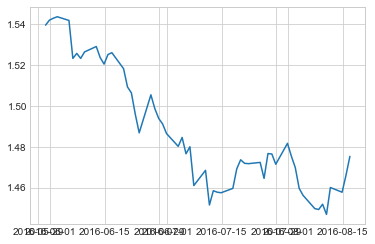

In [4]:
fig = plt.figure()
ax = plt.axes()

ax.plot(datetimes, close_prices)

# Using peakutils

In [39]:
import peakutils

Detecting peaks:

In [40]:
cb = np.array(close_prices)
indices = peakutils.indexes(cb, thres=0.50, min_dist=0.1)

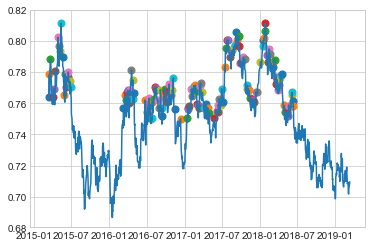

In [41]:
fig = plt.figure()
ax = plt.axes()

ax.plot(datetimes, close_prices)
for ix in indices:
    plt.scatter(datetimes[ix],close_prices[ix], s=50)

Detecting valleys:

In [42]:
indices = peakutils.indexes(-cb, thres=0.50, min_dist=0.1)

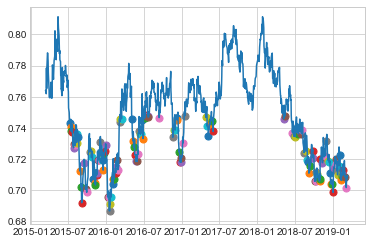

In [43]:
fig = plt.figure()
ax = plt.axes()

ax.plot(datetimes, close_prices)
for ix in indices:
    plt.scatter(datetimes[ix],close_prices[ix], s=50)

## Another example dataset
This set of prices that has caused me issues while doing my analyses. Let's get the candle data:

In [44]:
oanda=OandaAPI(url='https://api-fxtrade.oanda.com/v1/candles?',
               instrument='EUR_USD',
               granularity='H12',
               alignmentTimezone='Europe/London',
               dailyAlignment=22
              )

oanda.run(start='2018-04-18T22:00:00',
          end='2018-06-21T22:00:00')

In [45]:
close_prices1=[]
datetimes1=[]
for c in oanda.fetch_candleset():
    close_prices1.append(c.closeAsk)
    datetimes1.append(c.time)

<Figure size 432x288 with 0 Axes>

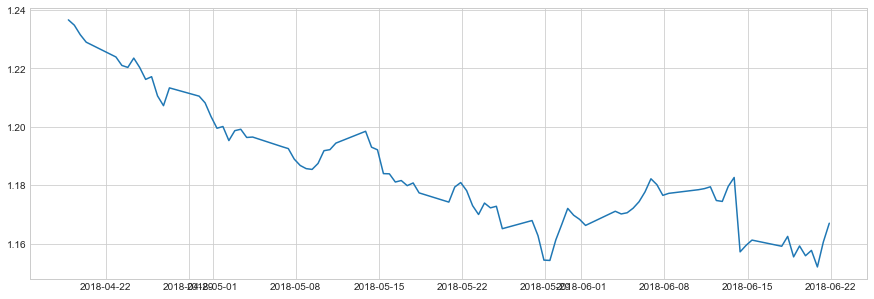

In [46]:
fig = plt.figure()
plt.figure(figsize=(15, 5))
ax = plt.axes()

ax.plot(datetimes1, close_prices1)

We are interesing in detecting these big 2 valleys below 1.16 (one around 06/2018 and the other around 05/2018):

In [47]:
cb1 = np.array(close_prices1)
indices1 = peakutils.indexes(-cb1, thres=0.50, min_dist=0.1)
print(len(indices1))

17


<Figure size 432x288 with 0 Axes>

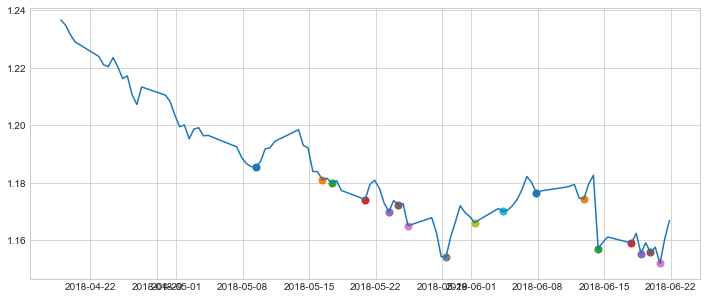

In [48]:
fig = plt.figure()
plt.figure(figsize=(12, 5))
ax = plt.axes()
ax.plot(datetimes1, close_prices1)
for ix in indices1:
    plt.scatter(datetimes1[ix],close_prices1[ix], s=50)

We see that the interesting valleys are picked, but also a lot of other different noisy (false positive) valleys.
One strategy for getting rid of these valleys will consist on smoothing the data before detecting valleys:

* Smoothing with the rolling average
Let's use in this case a window size (k) of 12 candles for calculating the rolling average

First, let's create a dataframe with the `datetimes1` and `close_prices1`:

In [49]:
d = {'times': datetimes1 , 'prices': close_prices1}
df = pd.DataFrame(data=d)

Then, we perform the smoothing:

In [50]:
df['prices_norm']=df[['prices']].rolling(2).mean()

And if we plot the smoothed prices:

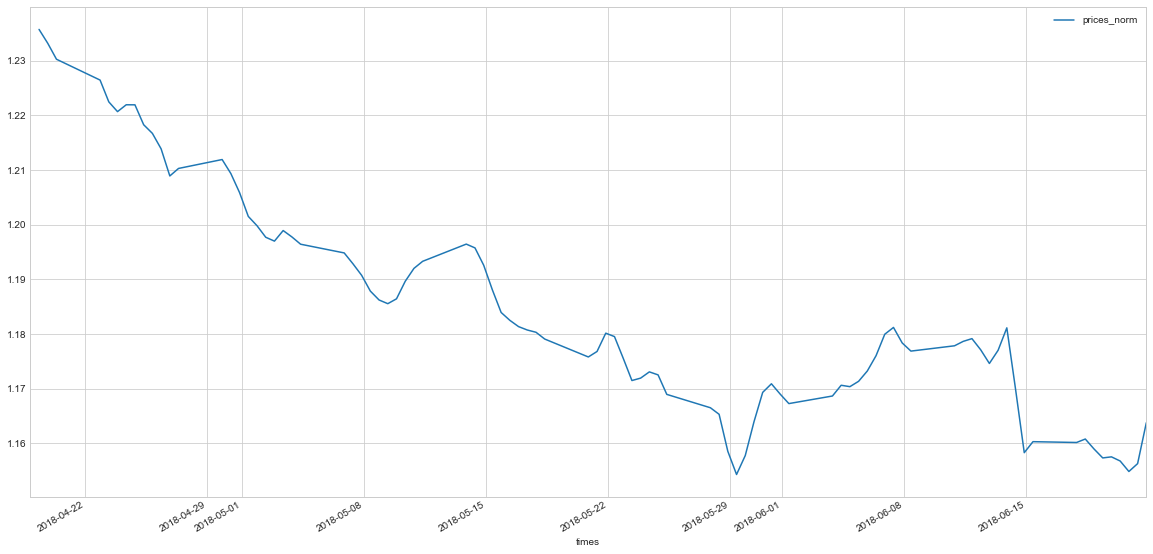

In [51]:
ax = df.plot(x='times', y='prices_norm',figsize=(20, 10))

In [52]:
cb1 = np.array(df['prices_norm'])
indices1 = peakutils.indexes(-cb1, thres=0.01, min_dist=0.1)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/peakutils/peak.py:84: RuntimeWarning: invalid value encountered in less
  & (np.greater(y, thres)))[0]
/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/peakutils/peak.py:84: RuntimeWarning: invalid value encountered in greater
  & (np.greater(y, thres)))[0]


In [53]:
print(indices1)

[]


We see that using the rolling average in order to smooth the data do not pick any valley. Let's use another smoothing
method:

# Using scipy.signal

Let's create some example data and use the polynomial fit to smooth the noisy data

In [54]:
# example data with peaks:
x = np.linspace(-1,3,1000)
data = -0.1*np.cos(12*x)+ np.exp(-(1-x)**2)

Plotting the data

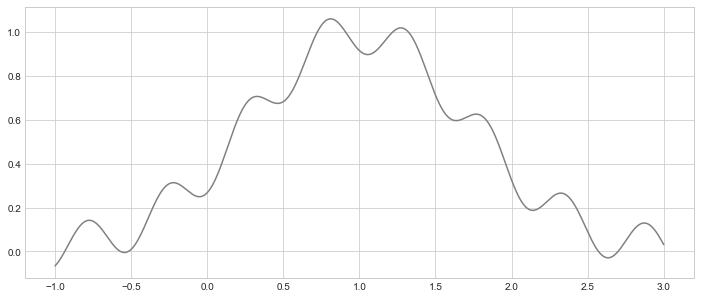

In [55]:
# plot
plt.figure(figsize=(12, 5))
plt.plot(x, data, color='grey')

In [56]:
from scipy.signal import argrelextrema

# for local maxima
max=argrelextrema(data, np.greater)

# for local minima
min=argrelextrema(data, np.less)

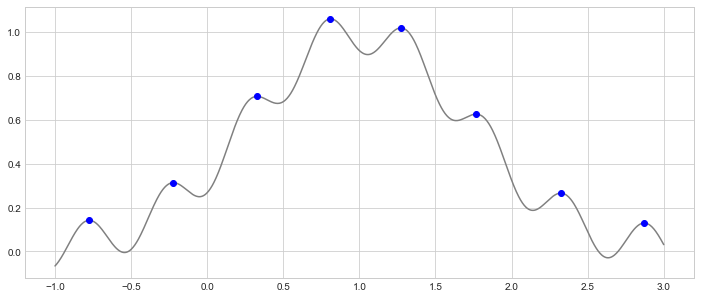

In [57]:
# maxima
# plot
plt.figure(figsize=(12, 5))
plt.plot(x, data, color='grey')
plt.plot(x[max], data[max], "o", label="max", color='b')

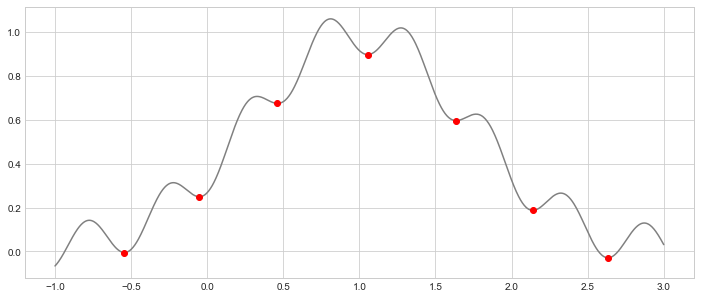

In [58]:
# minima
# plot
plt.figure(figsize=(12, 5))
plt.plot(x, data, color='grey')
plt.plot(x[min], data[min], "o", label="min", color='r')

## Now let's use the candle data retrieved before 

* Smoothing with the rolling average
Let's use in this case a window size (k) of 12 candles for calculating the rolling average

First, let's create a dataframe with the `datetimes` and `close_prices`:

In [59]:
d = {'times': datetimes , 'prices': close_prices}
df = pd.DataFrame(data=d)

Then, we perform the smoothing:

In [63]:
df['prices_norm']=df[['prices']].rolling(12).mean()

And if we plot the unsmoothed prices:

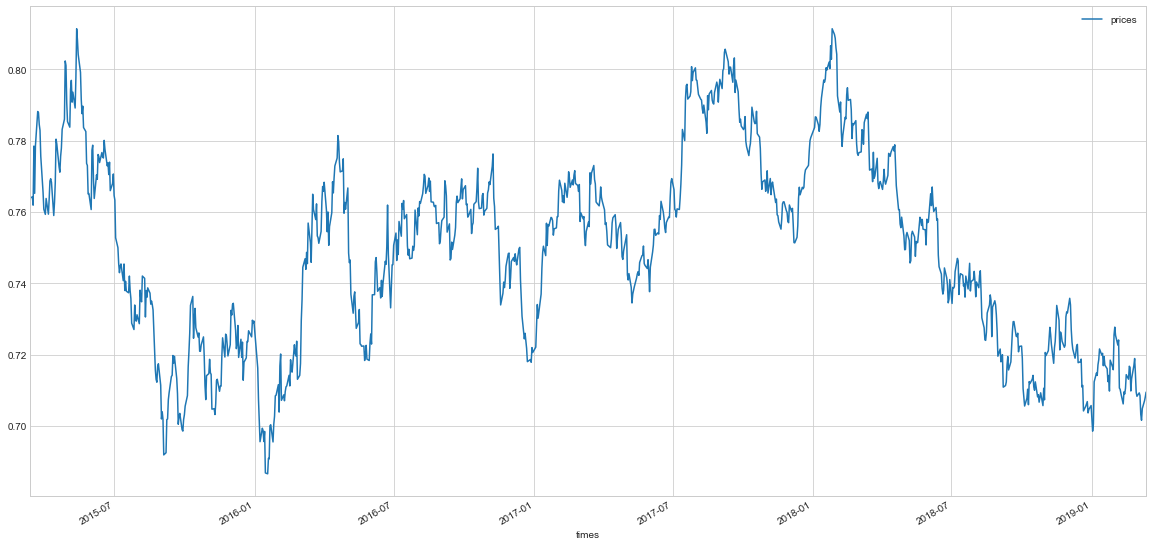

In [65]:
ax = df.plot(x='times', y='prices',figsize=(20, 10))

And if we plot the smoothed prices:

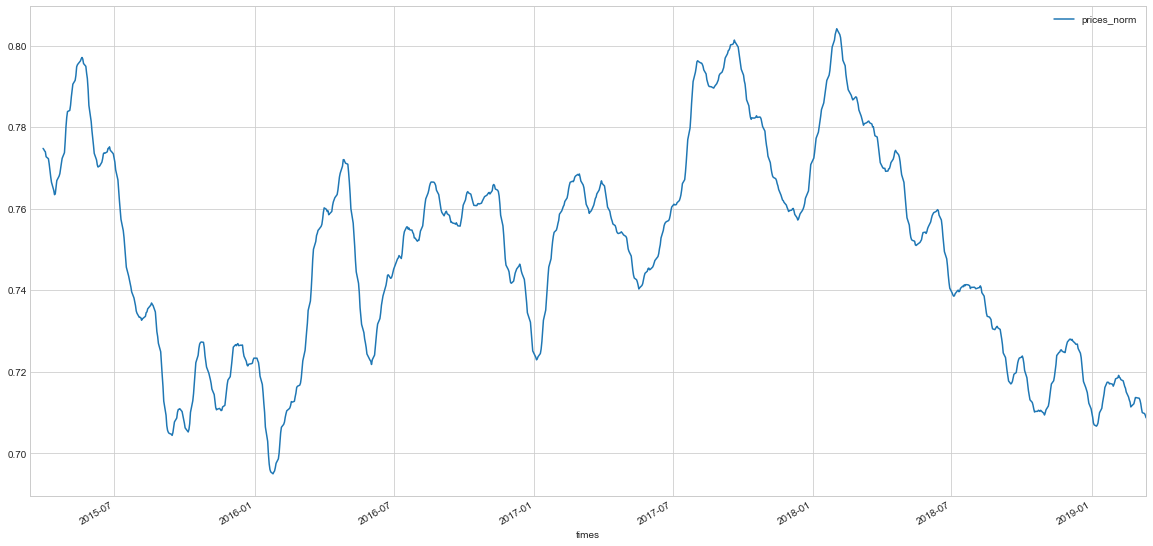

In [66]:
ax = df.plot(x='times', y='prices_norm',figsize=(20, 10))

In [69]:
# for local maxima
max=argrelextrema(np.array(df['prices_norm']), np.greater)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


In [70]:
# for local minima
min=argrelextrema(np.array(df['prices_norm']), np.less)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


Let's plot the identified local maxima and minima

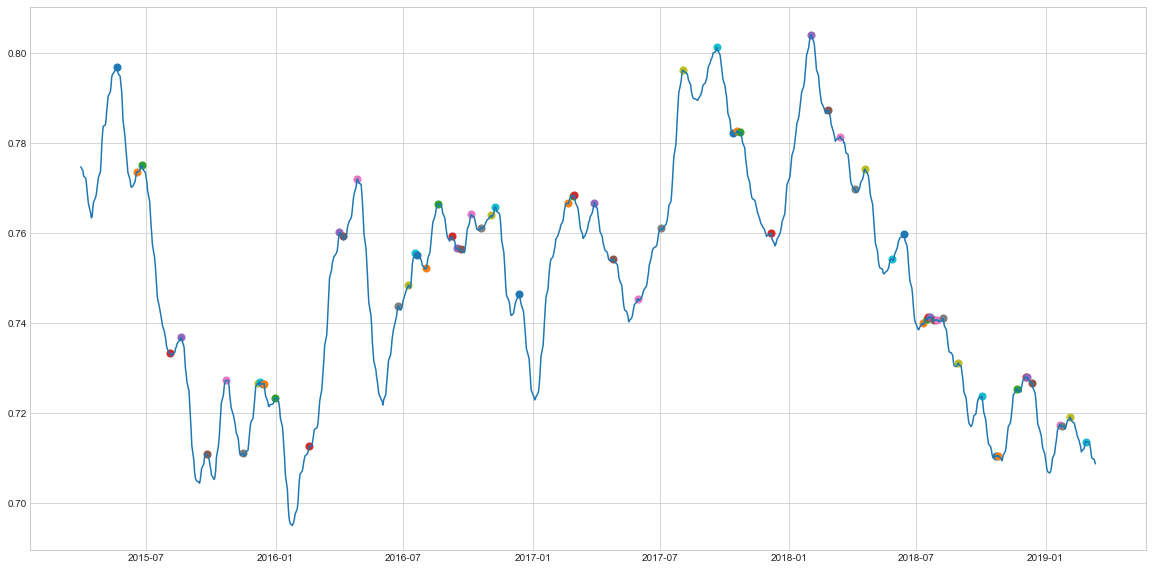

In [72]:
# maxima
# plot
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

ax.plot(datetimes, np.array(df['prices_norm']))
for ix in max[0]:
    plt.scatter(datetimes[ix],np.array(df['prices_norm'])[ix], s=50)

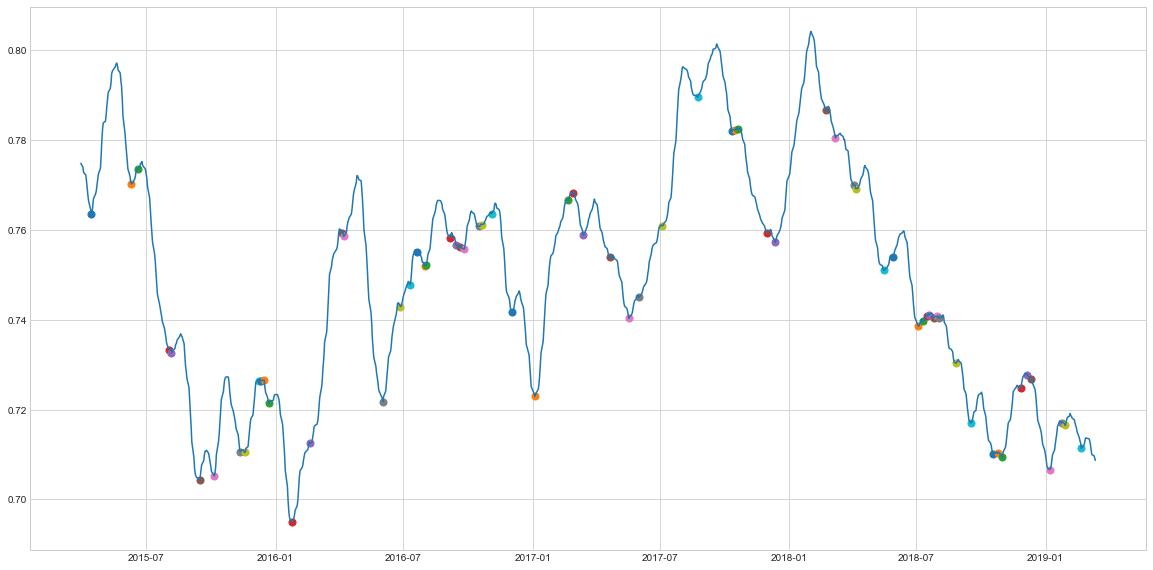

In [75]:
# minima
# plot
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

ax.plot(datetimes, np.array(df['prices_norm']))
for ix in min[0]:
    plt.scatter(datetimes[ix],np.array(df['prices_norm'])[ix], s=50)